In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from exp_utils import *

def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)

In [2]:
class Args:
    
    def __init__(self, dz, du, init_w_pca, num_states, obs_model):
        self.dz = dz
        self.du = du
        self.init_w_pca = init_w_pca
        self.num_states = num_states
        self.obs_model = obs_model

In [369]:
from run_experiment import HMM_class

def train_linear_SSM(x_tr, **kwargs):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(args.dz)
    om = observation_models.LinearObservationModel(dx, args.dz, noise_x=1.)
    
    if args.init_w_pca == 1:
        om.pca_init(x_tr)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, **kwargs):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(args.dz)
    om_hs = observation_models.HCCovObservationModel(dx, args.dz, args.du)
    if args.init_w_pca == 1:
        om_hs.pca_init(x_tr)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs)
    hs_model.om.C[:] *= 1e-10
    hs_model.run()
    
    return hs_model

def train_HMM(x_tr, **kwargs):
    return HMM_class(x_tr, args.num_states, args.obs_model)

In [382]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_synthetic_e1()
x_tr, x_va, x_te, x_te_na, s_tr_x = x_tr[:2000,:4], x_va[:,:2], x_te[:,:4], x_te_na, s_tr_x

In [379]:
x_tr.shape

(2000, 4)

In [409]:
dz, du = 4, 3
num_states, obs_model = 10, 'ar'
args = Args(dz, du, False, num_states, obs_model)

In [410]:
hmm = train_HMM(x_tr)

  0%|          | 0/100 [00:00<?, ?it/s]

In [399]:
hsk = train_linear_hsk_SSM(x_tr)

Iteration 2 - llk=-1562.3
Iteration 4 - llk=121.2
Iteration 6 - llk=1238.1
Iteration 8 - llk=1774.3
Iteration 10 - llk=2015.9
Iteration 12 - llk=2160.9
Iteration 14 - llk=2265.7
Iteration 16 - llk=2349.3
Iteration 18 - llk=2418.0
Iteration 20 - llk=2472.6
Iteration 22 - llk=2509.4
Iteration 24 - llk=2530.4
Iteration 26 - llk=2542.9
Iteration 28 - llk=2548.6
EM did converge.


In [400]:
lin = train_linear_SSM(x_tr)

Iteration 2 - llk=-4475.4
Iteration 4 - llk=-2195.6
Iteration 6 - llk=-684.4
Iteration 8 - llk=322.5
Iteration 10 - llk=785.8
Iteration 12 - llk=906.7
Iteration 14 - llk=943.2
Iteration 16 - llk=964.6
Iteration 18 - llk=980.5
Iteration 20 - llk=992.7
Iteration 22 - llk=1002.2
Iteration 24 - llk=1009.8
Iteration 26 - llk=1016.0
Iteration 28 - llk=1021.2
Iteration 30 - llk=1026.1
Iteration 32 - llk=1031.2
Iteration 34 - llk=1037.9
Iteration 36 - llk=1048.0
Iteration 38 - llk=1064.9
Iteration 40 - llk=1092.8
Iteration 42 - llk=1134.3
Iteration 44 - llk=1187.2
Iteration 46 - llk=1243.4
Iteration 48 - llk=1295.3
Iteration 50 - llk=1339.9
Iteration 52 - llk=1377.2
Iteration 54 - llk=1408.4
Iteration 56 - llk=1434.7
Iteration 58 - llk=1457.2
Iteration 60 - llk=1476.6
Iteration 62 - llk=1493.6
Iteration 64 - llk=1508.5
Iteration 66 - llk=1521.9
Iteration 68 - llk=1533.8
Iteration 70 - llk=1544.7
Iteration 72 - llk=1554.5
Iteration 74 - llk=1563.5
Iteration 76 - llk=1571.8
Iteration 78 - llk=15

In [429]:
x_te_corrupted = numpy.copy(x_te)
rand_idx = numpy.arange(200,800)#numpy.random.choice(numpy.arange(x_te.shape[0]), 100, replace=False)
#x_te_corrupted[rand_idx,0] -= 10 + numpy.random.randn(*x_te_corrupted[rand_idx,0].shape)
#x_te_corrupted[:,1] = numpy.nan
pred_density = hmm.compute_predictive_density(x_te_corrupted)
lb_hmm, ub_hmm = pred_density.mu - 1.96 * pred_density.Sigma, pred_density.mu + 1.96 * pred_density.Sigma

(5000, 4) (5000, 4)


In [437]:
#x_te_corrupted = numpy.copy(x_te)
rand_idx = numpy.arange(200,800)#numpy.random.choice(numpy.arange(x_te.shape[0]), 100, replace=False)
x_te_corrupted[rand_idx,0] += 5 #+ numpy.random.randn(*x_te_corrupted[rand_idx,:].shape)
#x_te_corrupted[:,0] = numpy.nan
pred_density = hsk.compute_predictive_density(x_te_corrupted)
lb_hsk, ub_hsk = pred_density.mu - 1.96 * pred_density.Sigma.diagonal(axis1=1,axis2=2), pred_density.mu + 1.96 * pred_density.Sigma.diagonal(axis1=1,axis2=2)

In [430]:
#x_te_corrupted = numpy.copy(x_te)
rand_idx = numpy.arange(200,800)#numpy.random.choice(numpy.arange(x_te.shape[0]), 100, replace=False)
#x_te_corrupted[rand_idx,0] *= 10# + numpy.random.randn(*x_te_corrupted[rand_idx,:].shape)
#x_te_corrupted[:,0] = numpy.nan
pred_density = lin.compute_predictive_density(x_te_corrupted)
lb_lin, ub_lin = pred_density.mu - 1.96 * pred_density.Sigma.diagonal(axis1=1,axis2=2), pred_density.mu + 1.96 * pred_density.Sigma.diagonal(axis1=1,axis2=2)

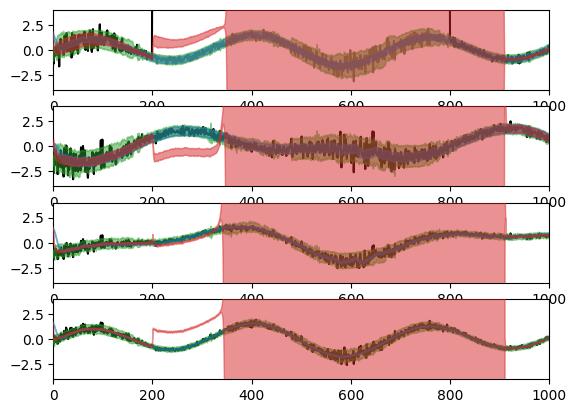

In [438]:
pyplot.rcdefaults()
for idx in range(4):
    pyplot.subplot(4,1,idx+1)
    pyplot.plot(x_te_corrupted[:,idx], 'k')
    pyplot.plot(x_te[:,idx], 'k', alpha=.5)
    #pyplot.plot(mean)
    pyplot.fill_between(range(lb_hsk.shape[0]), lb_hsk[:,idx], ub_hsk[:,idx], color='C3', zorder=9, alpha=.5)
    pyplot.fill_between(range(lb_hmm.shape[0]), lb_hmm[:,idx], ub_hmm[:,idx], color='C2', zorder=8, alpha=.5)
    pyplot.fill_between(range(lb_lin.shape[0]), lb_lin[:,idx], ub_lin[:,idx], color='C0', zorder=8, alpha=.5)
    pyplot.xlim([0,1000])
    pyplot.ylim([-4,4])

In [363]:
lin.compute_predictive_log_likelihood(x_te)

-2013.290776561465

In [394]:
hmm.compute_predictive_log_likelihood(x_te)

-3629.4797195217334

In [390]:
hsk.compute_predictive_log_likelihood(x_te)

-210383.55020395742

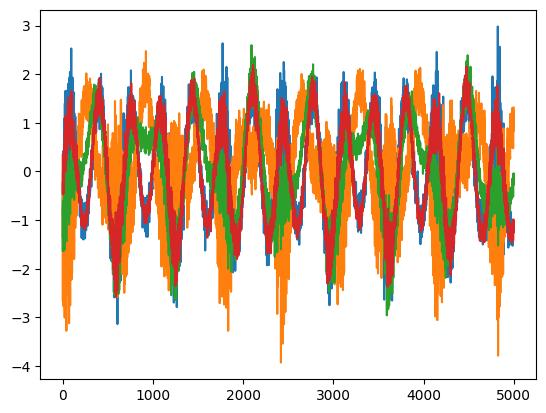

In [389]:
pyplot.plot(x_te)